In [8]:
#@title Load coordinates nearest points

#import all libraries
import time
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import entropy
from sklearn.metrics import classification_report
import warnings
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
from sklearn.pipeline import Pipeline





warnings.filterwarnings("ignore")

coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/distan_lat42.22lon-8.63p2R1Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [9]:
#@title Load station. Label variable and climatology
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/LEVXY2018Y2022.csv",
                          usecols = ["time","dir_o","spd_o"],
                          parse_dates=["time"]).set_index("time")

#wind direction to interval dir=-1 variable wind
interval = pd.IntervalIndex.from_tuples([(-1.5, -0.5),(-0.5,20), (20, 40), (40, 60),
                                           (60,80),(80,100),(100,120),(120,140),(140,160),
                                           (160,180),(180,200),(200,220),(220,240),
                                           (240,260),(260,280),(280,300),(300,320),
                                           (320,340),(340,360)])

labels = ['VRB', '[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]',
          '(100, 120]', '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]',
          '(200, 220]','(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]',
          '(300, 320]', '(320, 340]', '(340, 360]']

station["dir_l"] = pd.cut(station["dir_o"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")


#observed climatology
cli = station["dir_l"].value_counts(normalize= True).transform(lambda x: '{:,.0%}'.format(x))

#wind vrb intensity
station["spd_o_kt"]=np.rint(station["spd_o"]*1.94384)
print("\nwind intensity percentage (kt) when wind variable\n")
per = station[station.dir_l=="VRB"]["spd_o_kt"].value_counts(normalize = True).transform(lambda x: '{:,.0%}'.format(x))
display(per[:5])

#wind direction wind les or equal 3 kt
less3 = station[station.spd_o_kt<=3]["dir_l"].value_counts(normalize = True).transform(lambda x: '{:,.0%}'.format(x))
pd.concat([cli, less3], axis=1, keys=['Wind direction climatology', 'Wind direction (wind speed <=3 kt)'])


wind intensity percentage (kt) when wind variable



2.0    47%
1.0    26%
3.0    11%
4.0     7%
5.0     4%
Name: spd_o_kt, dtype: object

,Wind direction climatology,Wind direction (wind speed <=3 kt)
VRB,19%,54%
"(180, 200]",14%,3%
"(200, 220]",10%,3%
"[0, 20]",9%,12%
"(220, 240]",8%,4%
"(260, 280]",8%,2%
"(240, 260]",7%,3%
"(160, 180]",5%,2%
"(20, 40]",5%,3%
"(340, 360]",4%,3%


,dir_l,dir0_l,dir1_l
time,,,
2022-10-28 05:00:00,"(220, 240]","(200, 220]","(200, 220]"
2020-04-25 09:00:00,"(260, 280]","(120, 140]","(160, 180]"
2019-02-15 16:00:00,"(340, 360]","(40, 60]","(60, 80]"
2018-03-28 04:00:00,"(180, 200]","(140, 160]","(160, 180]"
2019-06-05 16:00:00,"(260, 280]","(260, 280]","(260, 280]"
2021-09-18 22:00:00,"[0, 20]","(340, 360]","[0, 20]"
2021-05-15 16:00:00,"(220, 240]","(220, 240]","(220, 240]"
2018-06-12 17:00:00,"(340, 360]","(280, 300]","(280, 300]"
2020-08-05 04:00:00,"(280, 300]","(300, 320]","(320, 340]"


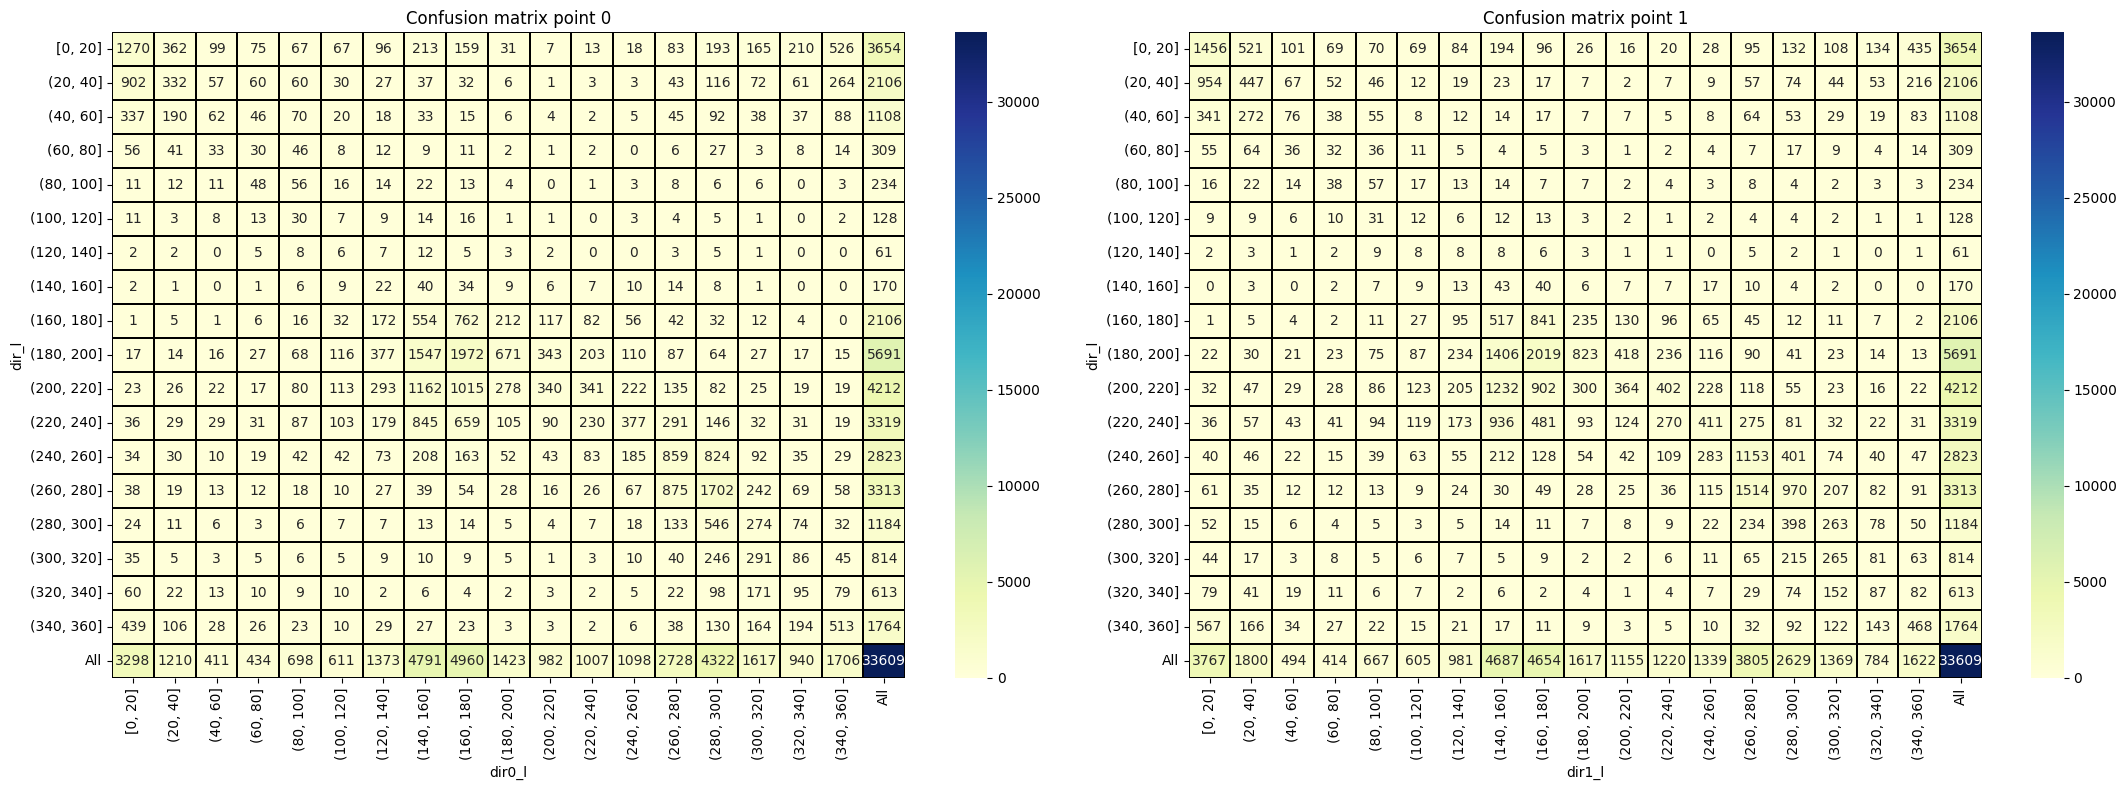

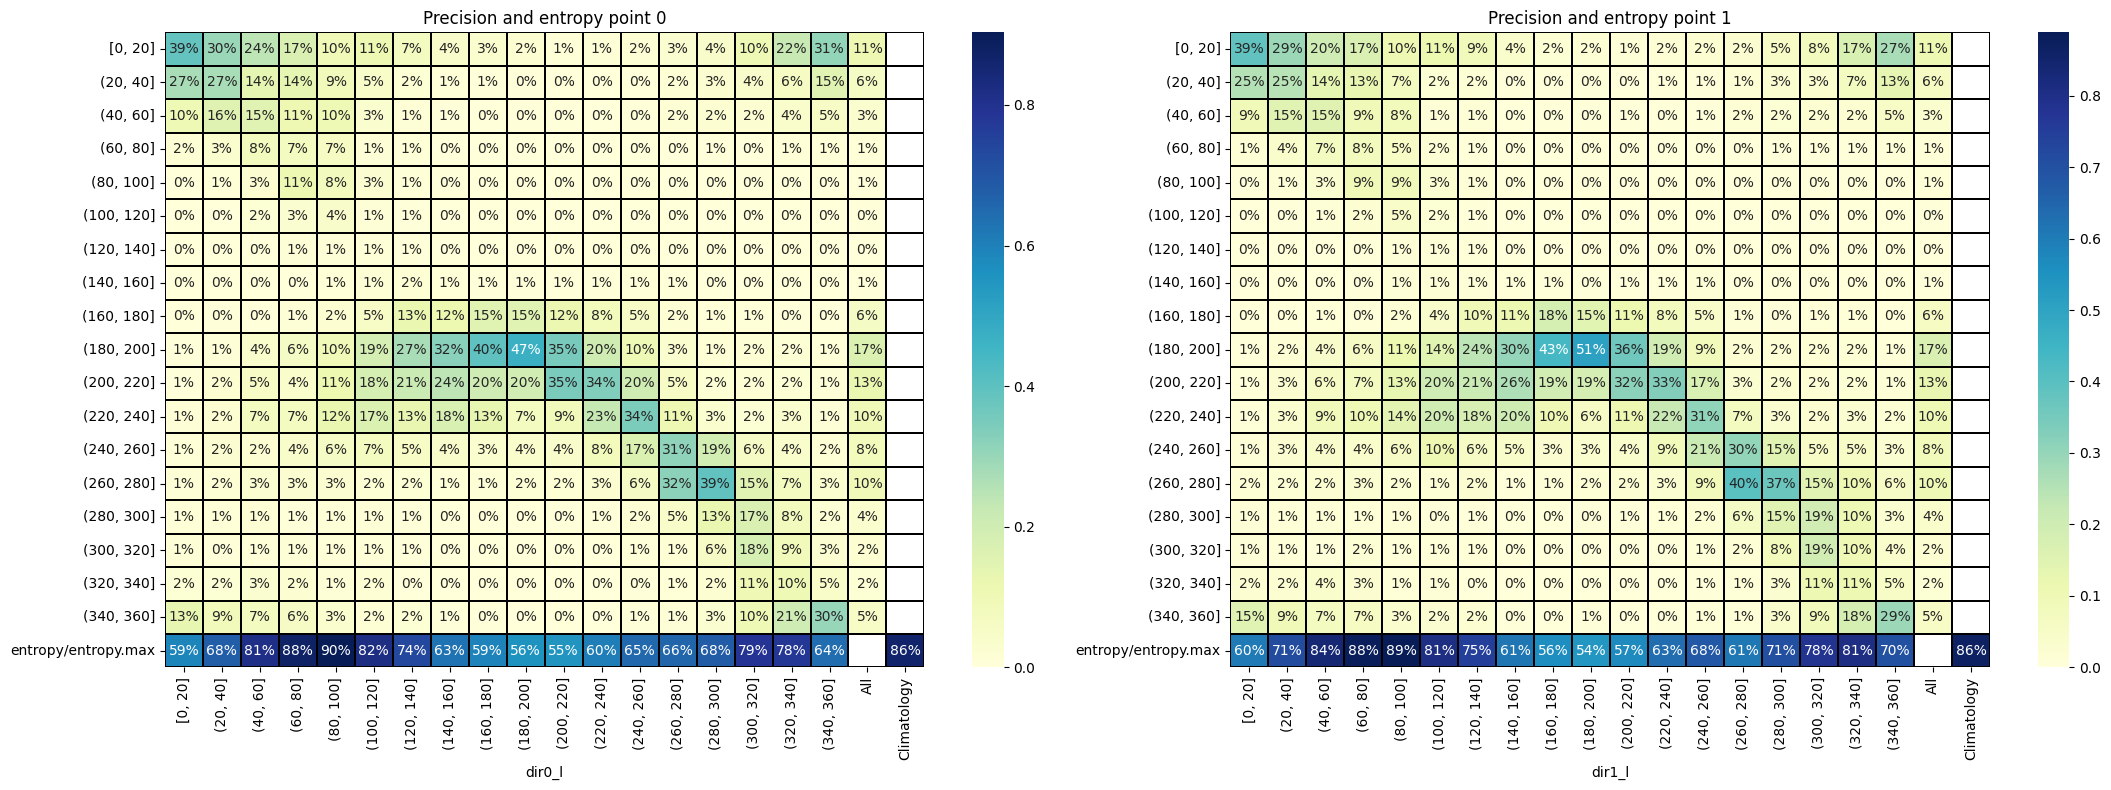

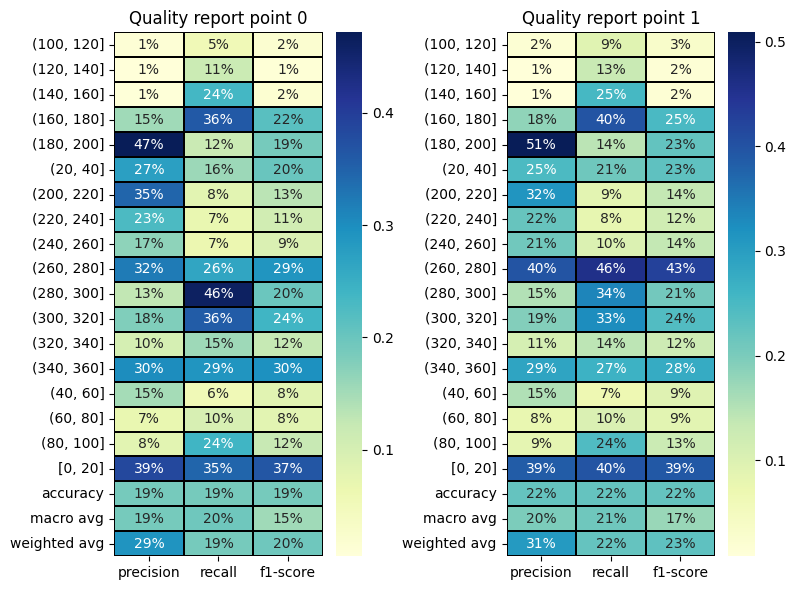

In [10]:
#@title Load meteorological model (Forecast D0). Concatenate station and meteorological model. Delete variable (VRB) observed direction. Label meteorological model variables dir0 and dir1. Confusion matrix point0 and point 1. Precision and entropy. Quality report
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2022.csv",parse_dates=["time"])
model1k = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station vs meteorological  model. Delete variable (VRB) observed direction
df_vrb = pd.concat([station,model1k],axis=1).drop(columns=["spd_o","spd_o_kt"]).dropna()
df_all1k = df_vrb[df_vrb.dir_o!=-1]
#display(df_all1k)

#label meteorological model variables dir0 and dir1
df_all1k["dir0_l"] = pd.cut(df_all1k["dir0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df_all1k["dir1_l"] = pd.cut(df_all1k["dir1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
#df_all1k["dir2_l"] = pd.cut(df_all1k["dir2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

display(df_all1k[["dir_l","dir0_l","dir1_l"]].sample(20))

# Confussion matrix
global_sc0 = pd.crosstab(df_all1k.dir_l, df_all1k.dir0_l,margins=True)
global_sc1 = pd.crosstab(df_all1k.dir_l, df_all1k.dir1_l,margins=True)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Plot heatmap 0
sns.heatmap(global_sc0, ax=axes[0], cmap="YlGnBu", annot=True,fmt='.0f',
                 linewidths=.2,linecolor='black')
axes[0].set_title("Confusion matrix point 0")

# Plot heatmap 2
sns.heatmap(global_sc1, ax=axes[1], cmap="YlGnBu", annot=True,fmt='.0f',
                 linewidths=.2,linecolor='black')
axes[1].set_title("Confusion matrix point 1")

# Adjust spacing between subplots
plt.tight_layout()

# Display the heatmaps
plt.show()


#Precision and entropy

column_sc0 = pd.crosstab(df_all1k.dir_l, df_all1k.dir0_l, margins=True,normalize="columns")
entropy_values = pd.DataFrame(
    entropy(column_sc0, base=2) / (math.log2(column_sc0.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc0.columns
).T
column_sc0 = pd.concat([column_sc0, entropy_values.rename(columns={"All": "Climatology"})])

column_sc1 = pd.crosstab(df_all1k.dir_l, df_all1k.dir1_l, margins=True,normalize="columns")
entropy_values = pd.DataFrame(
    entropy(column_sc1, base=2) / (math.log2(column_sc1.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc1.columns
).T
column_sc1 = pd.concat([column_sc1, entropy_values.rename(columns={"All": "Climatology"})])


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Plot heatmap 0
sns.heatmap(column_sc0, ax=axes[0], cmap="YlGnBu", annot=True,fmt='.0%',
                 linewidths=.2,linecolor='black')
axes[0].set_title("Precision and entropy point 0")

# Plot heatmap 2
sns.heatmap(column_sc1, ax=axes[1], cmap="YlGnBu", annot=True,fmt='.0%',
                 linewidths=.2,linecolor='black')
axes[1].set_title("Precision and entropy point 1")

# Adjust spacing between subplots
plt.tight_layout()

#Quality report

cr0 = pd.DataFrame(classification_report(df_all1k.dir_l, df_all1k.dir0_l,output_dict=True)).T
cr1 = pd.DataFrame(classification_report(df_all1k.dir_l, df_all1k.dir1_l,output_dict=True)).T


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Plot heatmap 0
sns.heatmap(cr0.drop(columns=["support"]), ax=axes[0], cmap="YlGnBu", annot=True,fmt='.0%',
                 linewidths=.2,linecolor='black')
axes[0].set_title("Quality report point 0")

# Plot heatmap 2
sns.heatmap(cr1.drop(columns=["support"]), ax=axes[1], cmap="YlGnBu", annot=True,fmt='.0%',
                 linewidths=.2,linecolor='black')
axes[1].set_title("Quality report point 1")

# Adjust spacing between subplots
plt.tight_layout()

In [11]:
#@title Test association between observed variable and meteorological model (point 0) (Pearson’s chi square test). Significance level (alpha) = 0.01
#two way table
from scipy.stats import chi2_contingency

alpha = 0.01

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(pd.crosstab(df_all1k.dir_l,df_all1k.dir0_l))

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables

print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between meteorological model variables and observed values")
else:
    print("Retain H0,There is no association between meteorological model variables and observed values")


if pd.crosstab(df_all1k.dir_l,df_all1k.dir0_l).min().min()<5:
  print("All cells must be more than five!!!. No Chi square test posible")

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  289
Stadistic 46698.593791489606
Reject H0,There is an association between meteorological model variables and observed values
All cells must be more than five!!!. No Chi square test posible


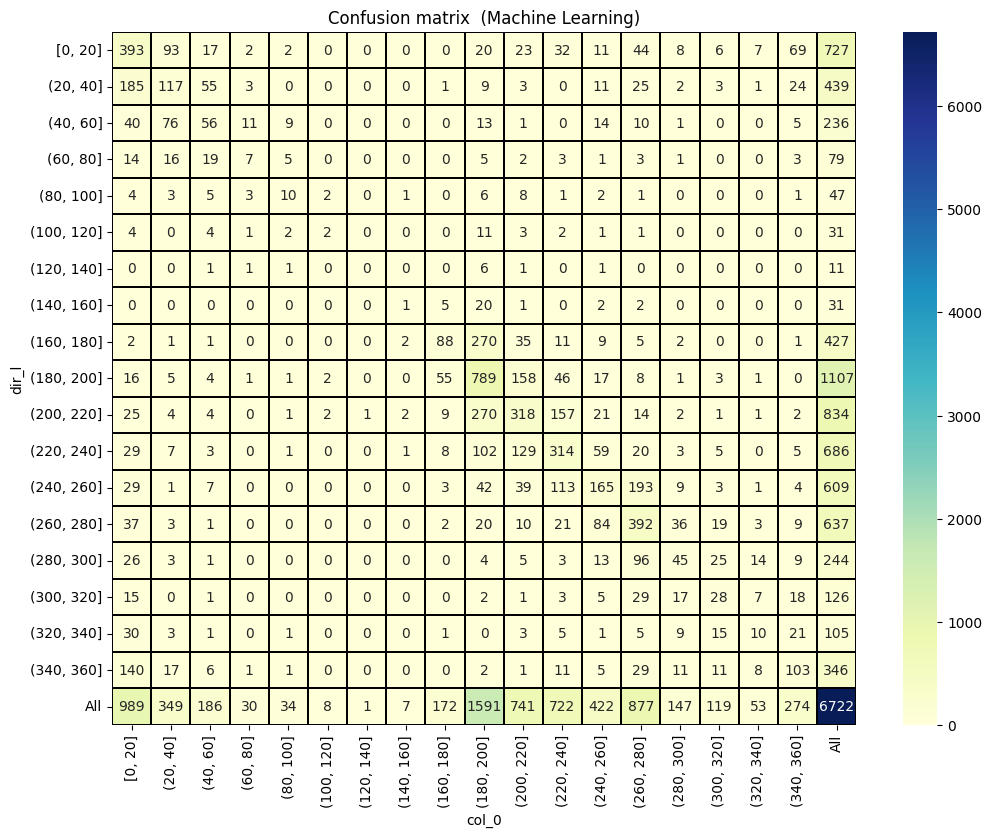

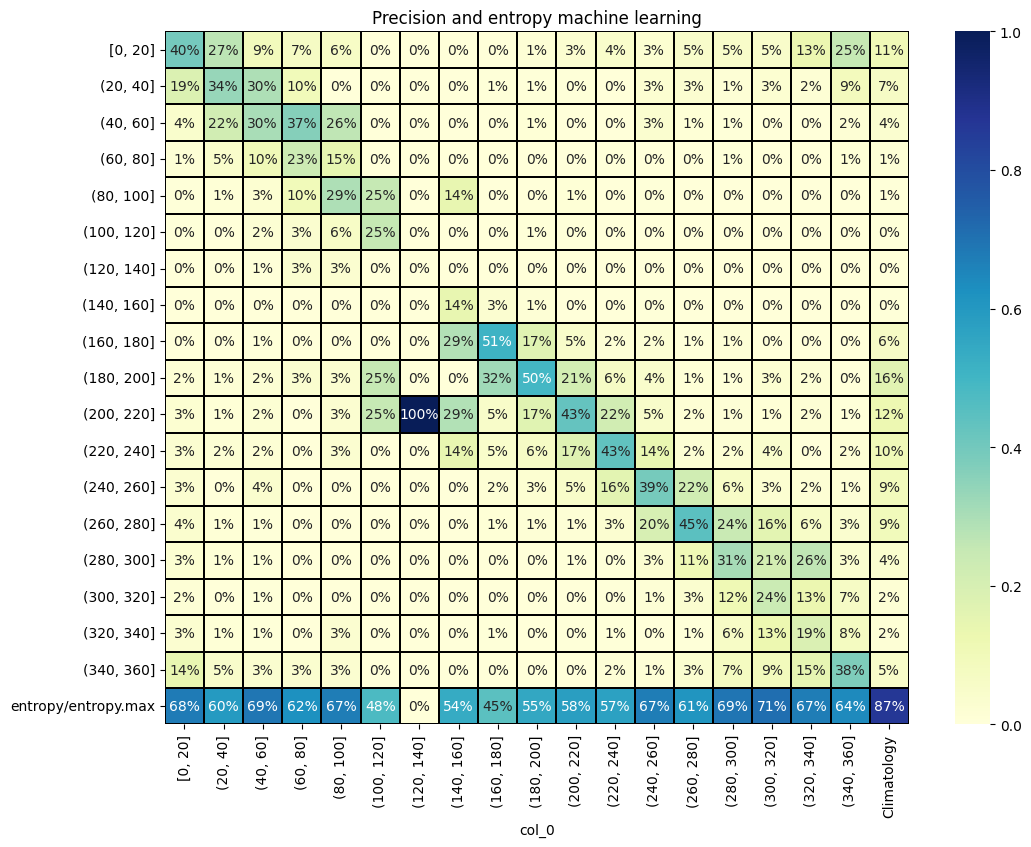

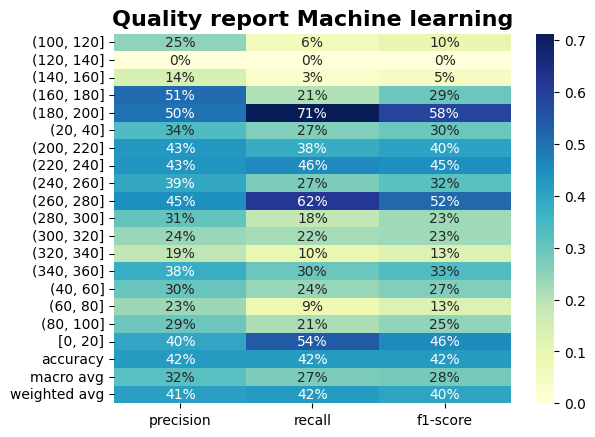

,feature,feature_per
25,dir1,5.2%
0,dir0,4.6%
52,dayofyear,3.6%
28,mod1,3.4%
29,wind_gust1,3.4%
3,mod0,3.3%
4,wind_gust0,3.1%
39,shflx1,3.0%
50,hour,3.0%
16,cin0,2.7%


Samples accuracy:  [0.42, 0.41, 0.42, 0.42, 0.42]
Execution time: 4.15 minutes


In [12]:
#@title Machine learning. Add time variables. Results without variable wind.
start_time = time.time()


df_vrb["hour"] = df_vrb.index.hour
df_vrb["month"] = df_vrb.index.month
df_vrb["dayofyear"] = df_vrb.index.dayofyear
df_vrb["weekofyear"] = df_vrb.index.isocalendar().week.astype(int)

df_all1k["hour"] = df_all1k.index.hour
df_all1k["month"] = df_all1k.index.month
df_all1k["dayofyear"] = df_all1k.index.dayofyear
df_all1k["weekofyear"] = df_all1k.index.isocalendar().week.astype(int)

# X and Y
Y = df_all1k.dir_l
X = df_all1k.iloc[:,2:].drop(columns=["dir0_l","dir1_l"])

# mean accuracy machine learning sample array
acc_ml_a = []

#seed random function to create TWO RELATED samples of scores
np.random.seed(1)

for t in range (0,5):
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, )

  #ml_model = RandomForestClassifier().fit(X_train,y_train)
  ml_model = LGBMClassifier().fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier().fit(X_train,y_train)

  y_pred = ml_model.predict(X_test)
  acc_ml_a.append(round(accuracy_score(y_test, y_pred),2))

  if t==4: #Show results last machine learning model
    #Confusion matrix
    plt.figure(figsize=(12, 9))
    plt.title("Confusion matrix  (Machine Learning)")
    cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
    comuns = [element for element in labels+["All"] if element in cm.columns]
    seab = sns.heatmap(cm[comuns],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    plt.figure(figsize=(12, 9))
    plt.title("Precision and entropy machine learning")
    column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
    column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                      index=column_sc.columns).T).rename(columns={"All":"Climatology"})
    comuns = [element for element in labels+["Climatology"] if element in column_sc.columns]
    seab = sns.heatmap(column_sc[comuns],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()

    df_d = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T.iloc[:, :3]
    seab = sns.heatmap(df_d,annot=True,cmap="YlGnBu",fmt='.0%',)
    seab.set_title("Quality report Machine learning", fontsize=16, fontweight='bold')
    plt.show()

    #feature importance
    def format_as_percentage(value):
        return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])

print("Samples accuracy: ",acc_ml_a)

#time
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", round(execution_time/60,2), "minutes")


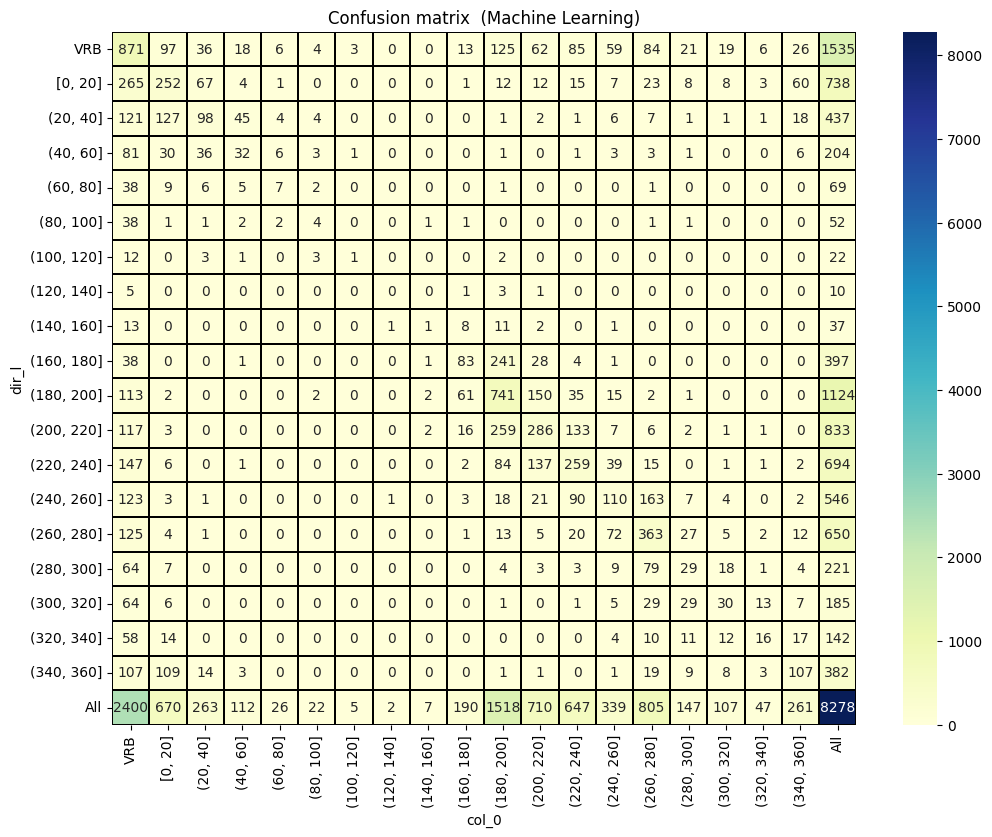

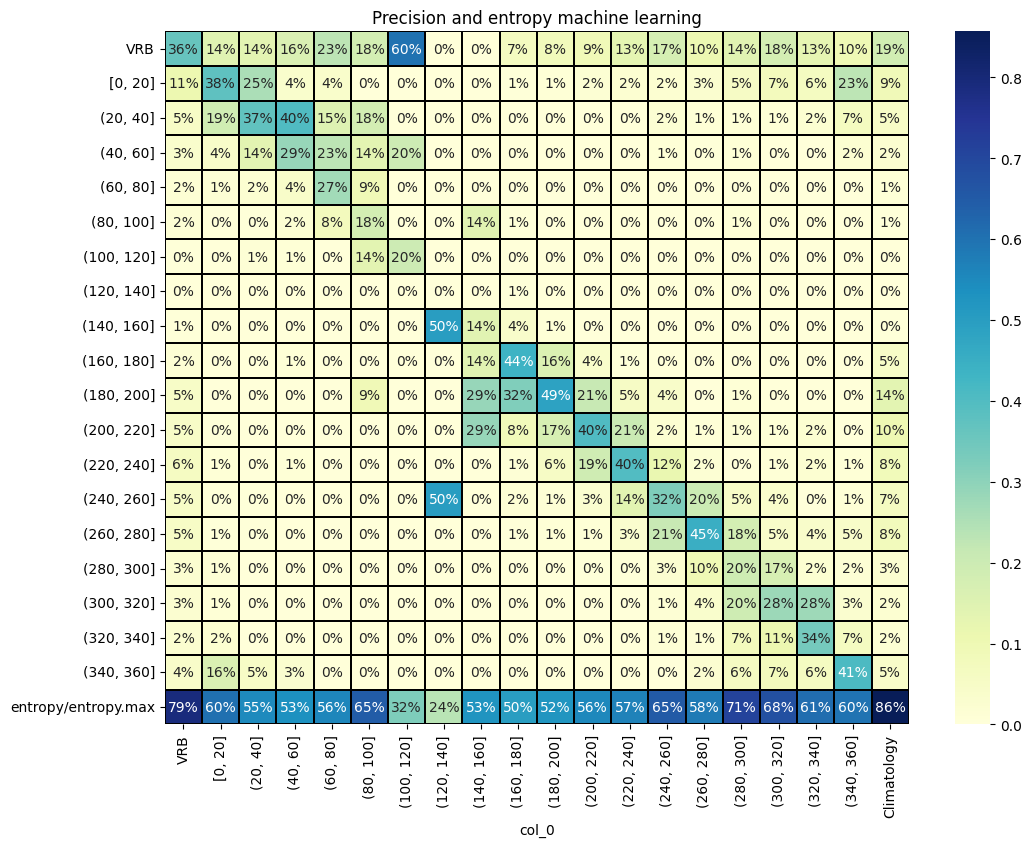

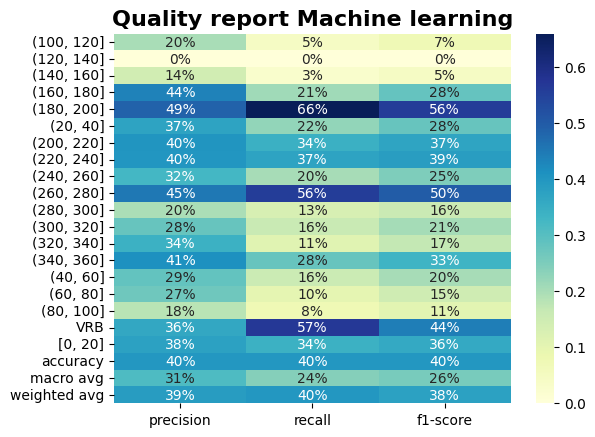

,feature,feature_per
25,dir1,5.2%
0,dir0,4.7%
52,dayofyear,3.6%
28,mod1,3.6%
29,wind_gust1,3.3%
3,mod0,3.2%
50,hour,3.1%
4,wind_gust0,3.1%
39,shflx1,2.9%
14,shflx0,2.9%


Samples accuracy:  [0.4, 0.4, 0.41, 0.4, 0.4]
Execution time: 2.76 minutes


In [7]:
#@title Machine learning. Results with variable wind. Download algorithm
start_time = time.time()

# X and Y
Y = df_vrb.dir_l
X = df_vrb.iloc[:,2:]

# mean accuracy machine learning sample array
acc_ml_a = []

#seed random function to create TWO RELATED samples of scores
np.random.seed(1)

for t in range (0,5):
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, )

  #ml_model = RandomForestClassifier().fit(X_train,y_train)
  ml_model = LGBMClassifier().fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier().fit(X_train,y_train)

  y_pred = ml_model.predict(X_test)
  acc_ml_a.append(round(accuracy_score(y_test, y_pred),2))

  if t==4: #show last machine learning result
    #Confusion matrix
    plt.figure(figsize=(12, 9))
    plt.title("Confusion matrix  (Machine Learning)")
    cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
    comuns = [element for element in labels+["All"] if element in cm.columns]
    seab = sns.heatmap(cm[comuns],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    plt.figure(figsize=(12, 9))
    plt.title("Precision and entropy machine learning")
    column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
    column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                     index=column_sc.columns).T).rename(columns={"All":"Climatology"})
    comuns = [element for element in labels+["Climatology"] if element in column_sc.columns]
    seab = sns.heatmap(column_sc[comuns],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()


    df_d = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T.iloc[:, :3]
    seab = sns.heatmap(df_d,annot=True,cmap="YlGnBu",fmt='.0%',)
    seab.set_title("Quality report Machine learning", fontsize=16, fontweight='bold')
    plt.show()

    #feature importance
    def format_as_percentage(value):
       return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                       "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])

print("Samples accuracy: ",acc_ml_a)

#download algorithm
x_var = X.columns
score = {"acc_met":float((cr0[-3:-2]["precision"]+cr1[-3:-2]["precision"])/2),"acc_ml":acc_ml_a[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/dir_LEVX_d0.al", 'wb'))

#time
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", round(execution_time/60,2), "minutes")


,dir_l,dir0_l,dir1_l
time,,,
2019-08-08 15:00:00,"(180, 200]","(160, 180]","(160, 180]"
2020-07-14 19:00:00,"[0, 20]","[0, 20]","[0, 20]"
2020-12-14 23:00:00,"(200, 220]","(280, 300]","(260, 280]"
2022-09-13 03:00:00,"(200, 220]","(120, 140]","(120, 140]"
2020-12-07 22:00:00,"(300, 320]","(300, 320]","(300, 320]"
2018-09-28 15:00:00,"(240, 260]","(260, 280]","(260, 280]"
2019-10-24 11:00:00,"(180, 200]","(220, 240]","(220, 240]"
2020-08-02 15:00:00,"(240, 260]","(340, 360]","(340, 360]"
2018-10-18 15:00:00,"[0, 20]","(20, 40]","(20, 40]"


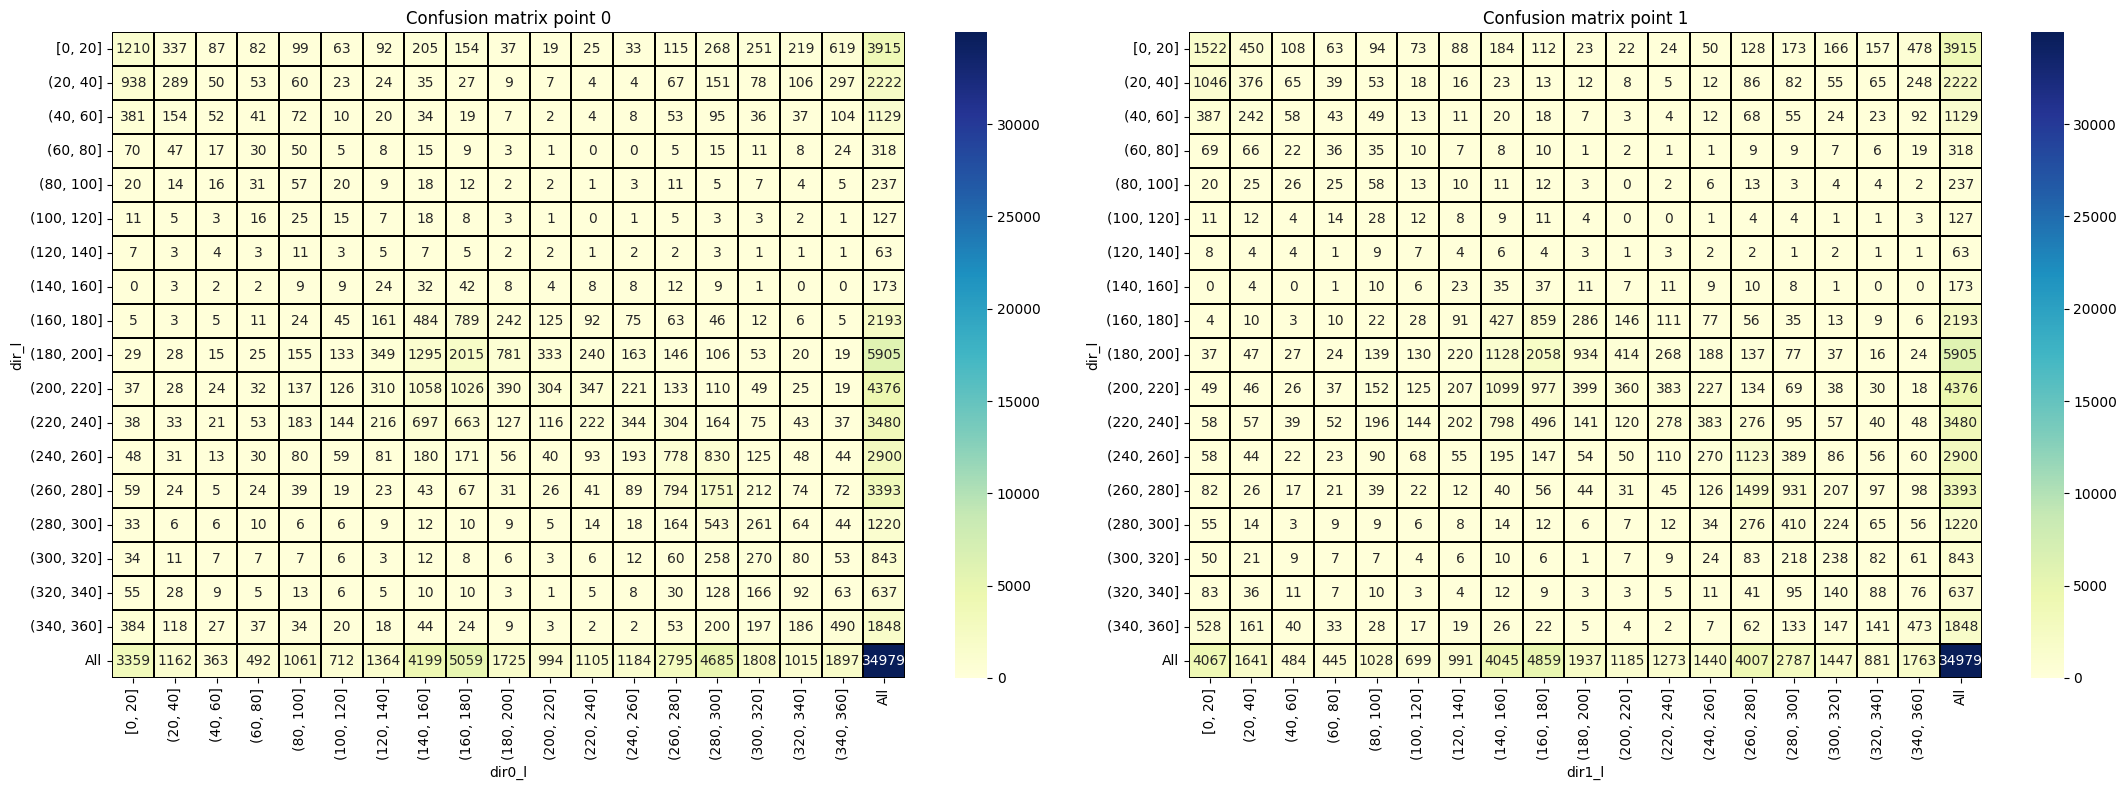

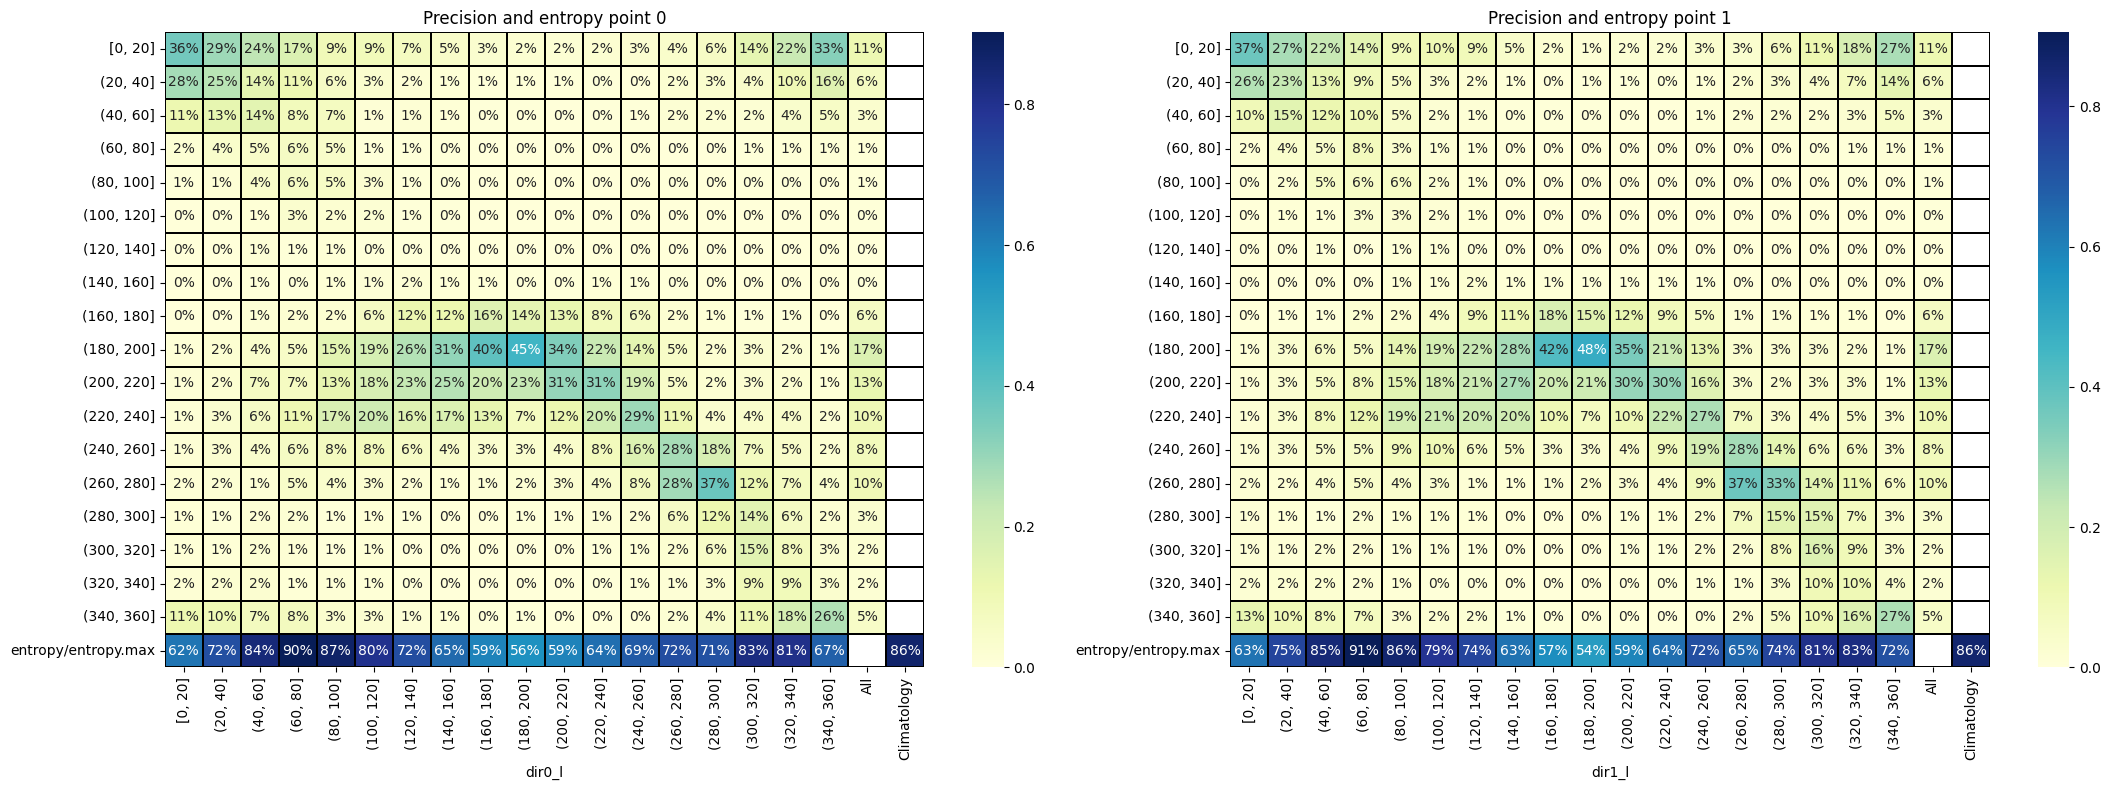

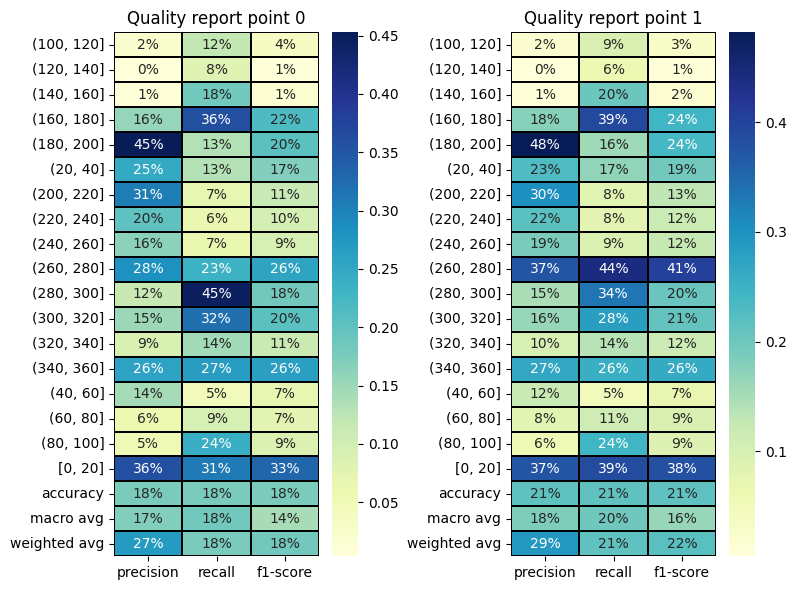

In [13]:
#@title Load meteorological model (Forecast D1). Concatenate station and meteorological model. Delete variable (VRB) observed direction. Label meteorological model variables dir0 and dir1. Confusion matrix point0 and point 1. Precision and entropy. Quality report
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2022.csv",parse_dates=["time"])
model1k = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station vs meteorological  model. Delete variable (VRB) observed direction
df_vrb = pd.concat([station,model1k],axis=1).drop(columns=["spd_o","spd_o_kt"]).dropna()
df_all1k = df_vrb[df_vrb.dir_o!=-1]
#display(df_all1k)

#label meteorological model variables dir0 and dir1
df_all1k["dir0_l"] = pd.cut(df_all1k["dir0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df_all1k["dir1_l"] = pd.cut(df_all1k["dir1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
#df_all1k["dir2_l"] = pd.cut(df_all1k["dir2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

display(df_all1k[["dir_l","dir0_l","dir1_l"]].sample(20))

# Confussion matrix
global_sc0 = pd.crosstab(df_all1k.dir_l, df_all1k.dir0_l,margins=True)
global_sc1 = pd.crosstab(df_all1k.dir_l, df_all1k.dir1_l,margins=True)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Plot heatmap 0
sns.heatmap(global_sc0, ax=axes[0], cmap="YlGnBu", annot=True,fmt='.0f',
                 linewidths=.2,linecolor='black')
axes[0].set_title("Confusion matrix point 0")

# Plot heatmap 2
sns.heatmap(global_sc1, ax=axes[1], cmap="YlGnBu", annot=True,fmt='.0f',
                 linewidths=.2,linecolor='black')
axes[1].set_title("Confusion matrix point 1")

# Adjust spacing between subplots
plt.tight_layout()

# Display the heatmaps
plt.show()


#Precision and entropy

column_sc0 = pd.crosstab(df_all1k.dir_l, df_all1k.dir0_l, margins=True,normalize="columns")
entropy_values = pd.DataFrame(
    entropy(column_sc0, base=2) / (math.log2(column_sc0.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc0.columns
).T
column_sc0 = pd.concat([column_sc0, entropy_values.rename(columns={"All": "Climatology"})])

column_sc1 = pd.crosstab(df_all1k.dir_l, df_all1k.dir1_l, margins=True,normalize="columns")
entropy_values = pd.DataFrame(
    entropy(column_sc1, base=2) / (math.log2(column_sc1.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc1.columns
).T
column_sc1 = pd.concat([column_sc1, entropy_values.rename(columns={"All": "Climatology"})])


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Plot heatmap 0
sns.heatmap(column_sc0, ax=axes[0], cmap="YlGnBu", annot=True,fmt='.0%',
                 linewidths=.2,linecolor='black')
axes[0].set_title("Precision and entropy point 0")

# Plot heatmap 2
sns.heatmap(column_sc1, ax=axes[1], cmap="YlGnBu", annot=True,fmt='.0%',
                 linewidths=.2,linecolor='black')
axes[1].set_title("Precision and entropy point 1")

# Adjust spacing between subplots
plt.tight_layout()

#Quality report

cr0 = pd.DataFrame(classification_report(df_all1k.dir_l, df_all1k.dir0_l,output_dict=True)).T
cr1 = pd.DataFrame(classification_report(df_all1k.dir_l, df_all1k.dir1_l,output_dict=True)).T


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Plot heatmap 0
sns.heatmap(cr0.drop(columns=["support"]), ax=axes[0], cmap="YlGnBu", annot=True,fmt='.0%',
                 linewidths=.2,linecolor='black')
axes[0].set_title("Quality report point 0")

# Plot heatmap 2
sns.heatmap(cr1.drop(columns=["support"]), ax=axes[1], cmap="YlGnBu", annot=True,fmt='.0%',
                 linewidths=.2,linecolor='black')
axes[1].set_title("Quality report point 1")

# Adjust spacing between subplots
plt.tight_layout()

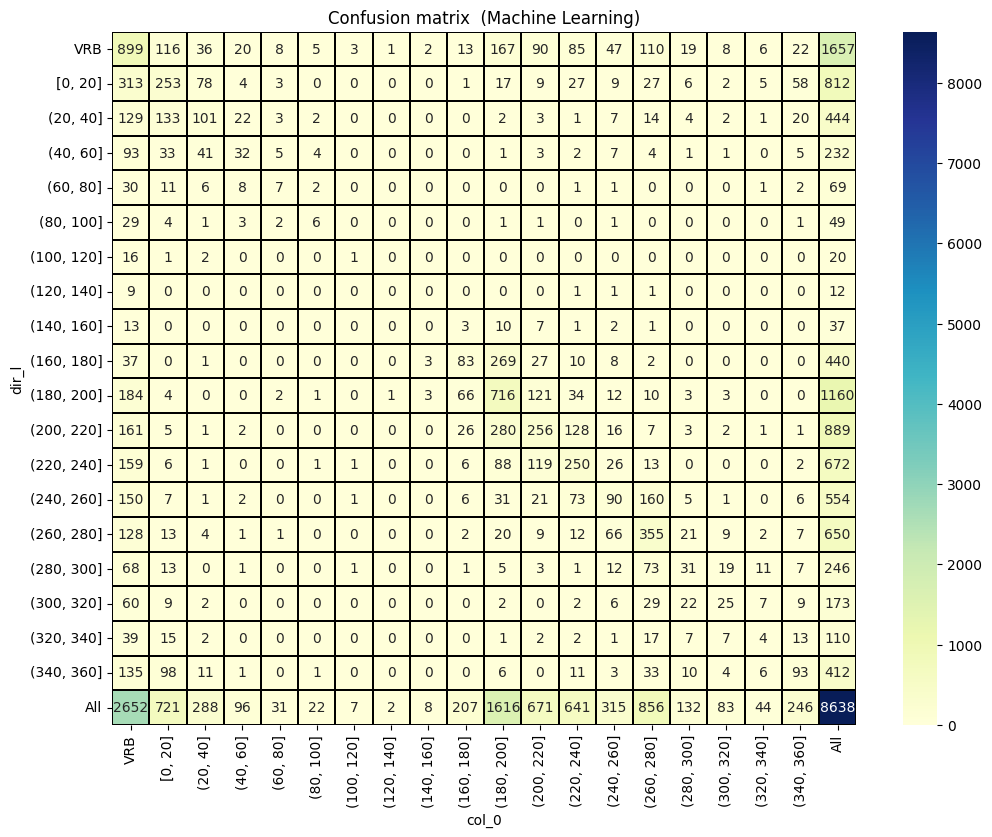

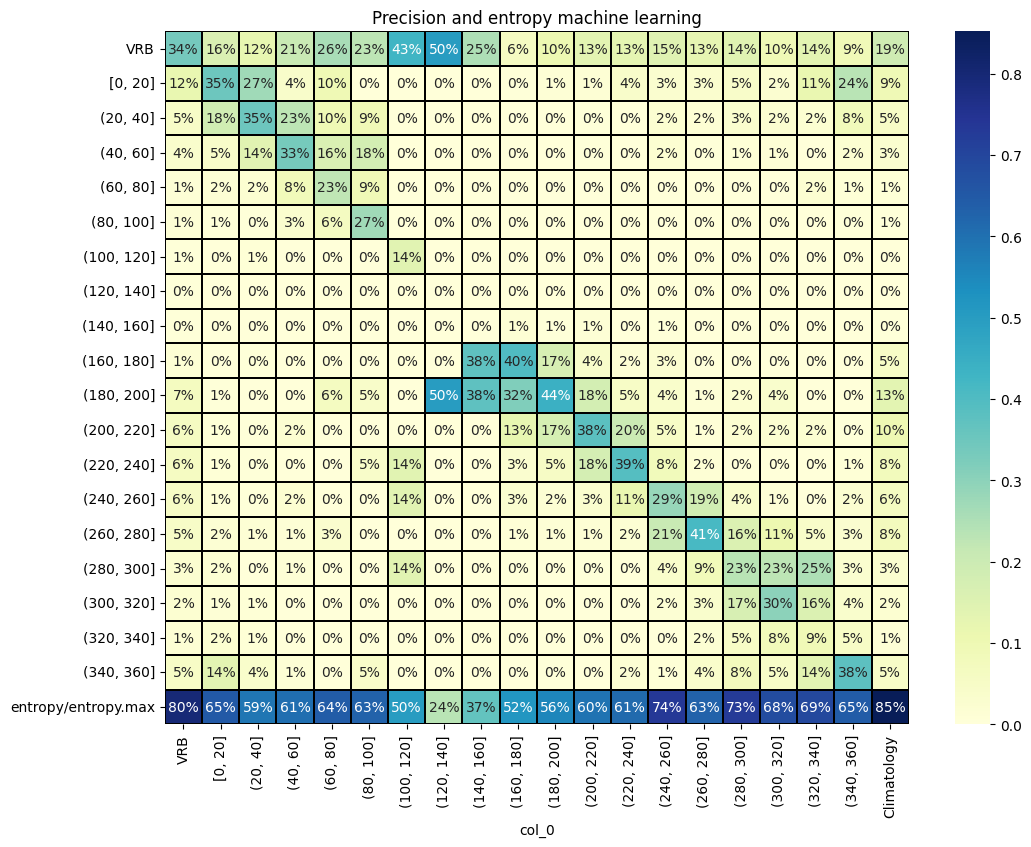

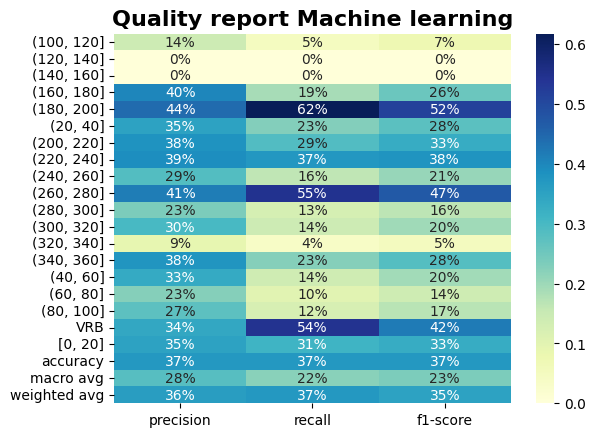

,feature,feature_per
25,dir1,5.0%
0,dir0,4.8%
28,mod1,3.4%
29,wind_gust1,3.3%
4,wind_gust0,3.2%
3,mod0,3.2%
39,shflx1,3.2%
14,shflx0,3.1%
16,cin0,3.0%
10,lwflx0,2.8%


Samples accuracy:  [0.37, 0.37, 0.38, 0.37, 0.37]
Execution time: 2.59 minutes


In [14]:
#@title Machine learning. Results with variable wind. Download algorithm
start_time = time.time()

# X and Y
Y = df_vrb.dir_l
X = df_vrb.iloc[:,2:]

# mean accuracy machine learning sample array
acc_ml_a = []

#seed random function to create TWO RELATED samples of scores
np.random.seed(1)

for t in range (0,5):
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, )

  #ml_model = RandomForestClassifier().fit(X_train,y_train)
  ml_model = LGBMClassifier().fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier().fit(X_train,y_train)

  y_pred = ml_model.predict(X_test)
  acc_ml_a.append(round(accuracy_score(y_test, y_pred),2))

  if t==4:
    #Confusion matrix
    plt.figure(figsize=(12, 9))
    plt.title("Confusion matrix  (Machine Learning)")
    cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
    comuns = [element for element in labels+["All"] if element in cm.columns]
    seab = sns.heatmap(cm[comuns],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    plt.figure(figsize=(12, 9))
    plt.title("Precision and entropy machine learning")
    column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
    column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                      index=column_sc.columns).T).rename(columns={"All":"Climatology"})
    comuns = [element for element in labels+["Climatology"] if element in column_sc.columns]
    seab = sns.heatmap(column_sc[comuns],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()


    df_d = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T.iloc[:, :3]
    seab = sns.heatmap(df_d,annot=True,cmap="YlGnBu",fmt='.0%',)
    seab.set_title("Quality report Machine learning", fontsize=16, fontweight='bold')
    plt.show()

    #feature importance
    def format_as_percentage(value):
        return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                       "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] = fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])

print("Samples accuracy: ",acc_ml_a)

#Download algorithm
x_var = X.columns
score = {"acc_met":float((cr0[-3:-2]["precision"]+cr1[-3:-2]["precision"])/2),"acc_ml":acc_ml_a[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/dir_LEVX_d1.al", 'wb'))

#time
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", round(execution_time/60,2), "minutes")
